In [1]:
import seaborn as sns
import metapack as mp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display 
from dtcv import get_image
import cv2

%matplotlib inline
sns.set_context('notebook')
mp.jupyter.init()


In [2]:
#pkg = mp.jupyter.open_package()
#pkg = mp.jupyter.open_source_package()
pkg = mp.open_package('http://library.metatab.org/sandiegodata.org-downtown_cv-5.zip')

pkg

# San Diego Downtown Homless Computer Vision Package
`sandiegodata.org-downtown_cv-5` Last Update: 2019-09-13T04:52:01

_Files and code for analyzing San Diego downtown homelessness  data with computer vision_


This dataset collects records related to a conversion of 5 years of paper maps
that record positions of homeless sleepers in downtown San Diego. The San Diego
Regional Data Library is [converting these paper maps to a digital
form](http://downtown-homelessness.sandiegodata.org/) with a manual process that
uses an image annotation tool, and theses annotations can be used to train
computer vision algorithms to georeference maps and recognize handwritten marks.

These datasets link to map urls and annotations, for three kinds of annotations:

* Ground Control Points, which identify the map image locations for known intersections, linking image coordinates ( in pixels ) to geographic coordinates.
* Image locations of handwritten marks and the number written in the mark.
* File annotations, for other handwritten notes such as the temperature and presence of rain. 

## More Information:

* [Blog Post](https://www.sandiegodata.org/2019/09/computer-vision-for-greater-good/). For more discussion about the GCP and handwritten marks, and the tasks in volved
in developing computer vision algorithms for these data, see our recent blog
post on the subject.
* [Clustering Notebook](https://nbviewer.jupyter.org/github/sandiegodata-projects/homelessness/blob/master/datasets/sandiegodata.org-downtown_cv/notebooks/Template%20Matching%20Clusters.ipynb). For some examples of using OpenCV to extract and match templates, to georeference maps, see the Templates and Clustering Jupyter Notebook].
* [Extract Marks Notebook](https://nbviewer.jupyter.org/github/sandiegodata-projects/homelessness/blob/master/datasets/sandiegodata.org-downtown_cv/notebooks/Extract%20Marks.ipynb). For examples of extracting ( but not recognizing ) handwritten marks, see this notebook. 


## Developer notes

After anotation JSON files are copied into S#, the list of S# urls must be
updated. To refresh the list of urls run

    $  bin/update_s3.sh <s3-profile>


 

## Contacts

* **Wrangler** [Eric Busboom](mailto:eric@civicknowledge.com), [Civic Knowledge](http://civicknowledge.com)

## Resources

* ** [gcp](data/gcp.csv)**. Ground control points
* ** [intersection_regions](data/intersection_regions.csv)**. Polygon transformations for each the intersections of each map
* ** [intersections](data/intersections.csv)**. List of intersections.
* ** [file_annotations](data/file_annotations.csv)**. File annotations on count files
* ** [counts](data/counts.csv)**. Annotation position, types and counts of handwritten marks

In [3]:
display(pkg.resource('counts'))
counts = pkg.resource('counts').dataframe()

Header,Type,Description
image_url,string,Map image URL
cx,integer,"X value of the center of the circle region, in pixels"
cy,integer,Y value of the center of the circle region in pixels
r,integer,"Radius of the circle region, in pixels"
type,string,"Type of sleeper: Individual, Vehicle or Structure"
count,string,Count of sleepers


In [4]:
# This may take a few minutes; it will download about 330 images and save them to the /tmp directory
counts['image'] = counts.image_url.apply(get_image)

counts['count'] = pd.to_numeric(counts['count'])

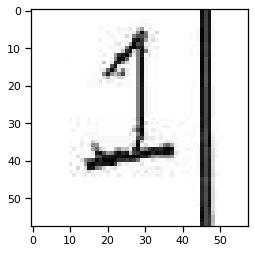

In [5]:
def crop(row):
    """Crop the handwritten mark, and hopefully the shape around it, from the image"""
    x, y, r = row.cx, row.cy, row.r
    
    r = int(r*1.0)
   
    return row.image[y-r:y+r, x-r:x+r ]

plt.imshow(crop(counts.iloc[60]))

4153


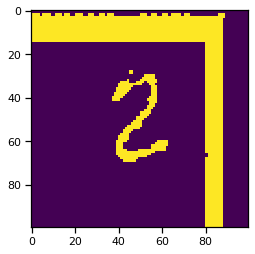

In [6]:
numbers = []

def invert(img):
    # Convert the img to grayscale 
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) 
    r = cv2.resize(gray, (100,100))
    _, tr = cv2.threshold (r, 70, 255, cv2.THRESH_BINARY_INV);
    return tr

for  name, row in  counts.iterrows():
    if row['count'] is not None and not np.isnan(row['count']) and row['count'] < 10 :
        numbers.append((row['count'], invert(crop(row))))
    
print(len(numbers))
plt.imshow(numbers[0][1])

In [7]:
'''Trains a simple convnet on the MNIST dataset.

Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128

epochs = 12


# the data, split between train and test sets
#(x_train, y_train), (x_test, y_test) = mnist.load_data()
# input image dimensions
#img_rows, img_cols = 28, 28


X = np.array([e[1] for e in numbers])
y = np.array([e[0] for e in numbers])

num_classes = len(np.unique(y))+1

l  = len(X)
train_l = int(l*.9)
x_train = X[:train_l]
y_train = y[:train_l]

x_test = X[train_l:]
y_test = y[train_l:]

img_rows, img_cols = x_train[0].shape


Using TensorFlow backend.
/Users/eric/anaconda3/envs/data36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/eric/anaconda3/envs/data36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/eric/anaconda3/envs/data36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/eric/anaconda3/e

In [9]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (3737, 100, 100, 1)
3737 train samples
416 test samples


In [ ]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 3737 samples, validate on 416 samples
Epoch 1/12
